# Check implementation with Guhdi's

In [1]:
import gudhi
import numpy as np
import matplotlib.pyplot as plt
from ripslayer import RipsLayer
import torch.nn as nn
import torch
import tensorflow as tf

2024-02-15 10:45:09.888943: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-15 10:45:09.934408: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 10:45:09.934439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 10:45:09.935702: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 10:45:09.943490: I tensorflow/core/platform/cpu_feature_guar

# Small example
Analogy between the tf and torch's implementation

In [2]:
# from gudhi.tensorflow.rips_layer import RipsLayer
from gudhi.wasserstein import wasserstein_distance

2024-02-15 10:45:16.734182: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21875 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:d5:00.0, compute capability: 8.6
/home/jmordacq/miniconda3/envs/difftda/lib/python3.9/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [3]:
np.random.seed(1)
angles = np.random.uniform(0,2*np.pi,100)
X = np.hstack([ np.cos(angles)[:,None], np.sin(angles)[:,None] ])
dim = 1
X = np.array([[0.1,0.],[1.5,1.5],[0.,1.6]])
dim = 0

#### tensorflow

In [4]:
XTF = tf.Variable(X, dtype=tf.float32)
lr = 1
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

num_epochs = 1
losses, Dgs, Xs, grads = [], [], [], []
for epoch in range(num_epochs+1):
    with tf.GradientTape() as tape:
        layer = RipsLayer(homology_dimensions=[dim], maximum_edge_length=10)
        dgm = layer.call(X=XTF)[0][0]
        loss = - wasserstein_distance(dgm, tf.constant(np.empty([0,2])), order=1, enable_autodiff=True)
    Dgs.append(dgm.numpy())            
    Xs.append(XTF.numpy())
    losses.append(loss.numpy())
    gradients = tape.gradient(loss, [XTF])
    grads.append(gradients[0].numpy())
    optimizer.apply_gradients(zip(gradients, [XTF]))

# X_torch = torch.tensor(X, dtype=torch.float32, requires_grad=True)
# lr = 1
# optimizer = torch.optim.SGD([X_torch], lr=lr)

# num_epochs = 1
# losses, Dgs, Xs, grads = [], [], [], []
# for epoch in range(num_epochs+1):
#     layer = RipsLayer(homology_dimensions=[dim], maximum_edge_length=10)
#     dgm = layer(X_torch)[0][0]
#     loss = - wasserstein_distance(dgm, np.empty([0,2]), order=1, enable_autodiff=True)
#     Dgs.append(dgm.detach().numpy())            
#     Xs.append(X_torch.detach().numpy())
#     losses.append(loss.detach().numpy())
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

2024-02-15 10:45:17.423604: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


2024-02-15 10:45:17.866549: I external/local_xla/xla/service/service.cc:168] XLA service 0x94bd9a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-15 10:45:17.866577: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6


2024-02-15 10:45:19.908914: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1707990319.998834 1669729 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


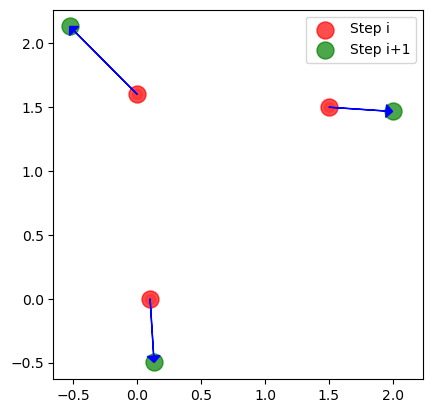

In [5]:
pts_to_move = np.argwhere(np.linalg.norm(grads[0], axis=1) != 0).ravel()
plt.figure()
for pt in pts_to_move:
    plt.arrow(Xs[0][pt,0], Xs[0][pt,1], -lr*grads[0][pt,0], -lr*grads[0][pt,1], color='blue',
              length_includes_head=True, head_length=.05, head_width=.1, zorder=10)
plt.scatter(Xs[0][:,0], Xs[0][:,1], c='red', s=50, alpha=.2,  zorder=3)
plt.scatter(Xs[0][pts_to_move,0], Xs[0][pts_to_move,1], c='red',   s=150, marker='o', zorder=2, alpha=.7, label='Step i')
plt.scatter(Xs[1][pts_to_move,0], Xs[1][pts_to_move,1], c='green', s=150, marker='o', zorder=1, alpha=.7, label='Step i+1')
plt.axis('square')
plt.legend()
plt.show()